## CS:GO Round Winner Classification

### 1. Introduction

Counter-Strike: Global Offensive (CS:GO) is a multiplayer first-person shooter developed by Valve and Hidden Path Entertainment.The game pits two teams, Terrorists and Counter-Terrorists, against each other in different objective-based game modes. The most common game modes involve the Terrorists planting a bomb while Counter-Terrorists attempt to stop them, or Counter-Terrorists attempting to rescue hostages that the Terrorists have captured.

Today we are going to analyze the dataset CS:GO Round Winner Classification from [Kaggle](https://www.kaggle.com/christianlillelund/csgo-round-winner-classification). 

### 2. Having a look at the data

The dataset consists of round snapshots from about 700 demos from high level tournament play in 2019 and 2020. Warmup rounds and restarts have been filtered, and for the remaining live rounds a round snapshot has been recorded every 20 seconds until the round is decided. Following its initial publication, It has been pre-processed and flattened to improve readability and make it easier for algorithms to process. The total number of snapshots is 122411. Snapshots are i.i.d and should be treated as individual data points, not as part of a match.

![Image 0](https://github.com/OriolBenitez/Cas_Kaggle/blob/main/pictures/csgo_example.png?raw=true)

At the picture above, we can observe some of the featues that are given in the data. 
We can see the guns and granades that the players have, the players who are alive(all excepting $rain$ and $Niko$), their live, if they are wearing helmet,etc

### 3. Data exploration and preprocessing

In [1]:
import sys
sys.path.insert(1, '../src/helpers')
sys.path.insert(1, '../src')
sys.path.insert(1, '../data')
from imports import *
from generate_features import *
from hyperparam_search import *
from scoring_model import *


In [2]:
dataset = pd.read_csv('../data/csgo_round_snapshots.csv')

In [3]:
dataset.head(5)

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


As the variable that we want to predict is the Round Winner, we can plot some stats to see if it is balanced

<AxesSubplot:xlabel='round_winner', ylabel='count'>

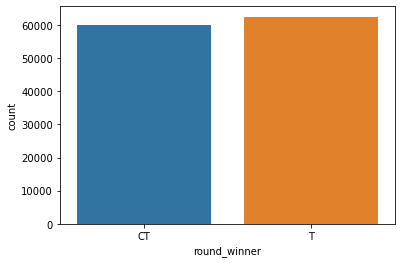

In [4]:
sns.countplot(data=dataset, x="round_winner")

Counter-Strike it is not always played at the same space(inside the game), there are maps, we can have a look at winning rate of each side(Terrorist or Counter-Terrorist) at every map.

<AxesSubplot:xlabel='map', ylabel='count'>

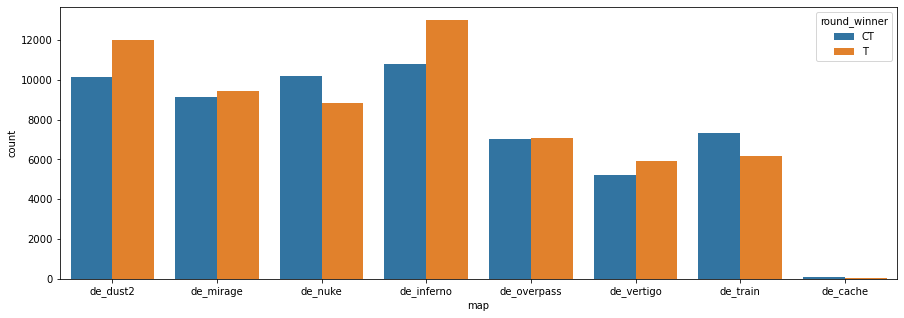

In [5]:
plt.figure(figsize = (15,5))
sns.countplot(x="map", data=dataset, hue=dataset["round_winner"])

We can observe that at maps like de_inferno and de_dust2 the Terrorist side have a better performance, otherwise, at de_train or de_nuke is de CT side the one with a better performance

Let's remove fetures that do not provide any information

In [6]:
dataset=remove_none_important_columns(dataset)

We can add some variables that might be usefull at the future. We can also use a Label encoder to convert categorical string into ints. 

In [7]:
dataset=convert_categorical_strings_to_int(dataset)
dataset=create_new_features(dataset)

Now, we can have a look at the correlations

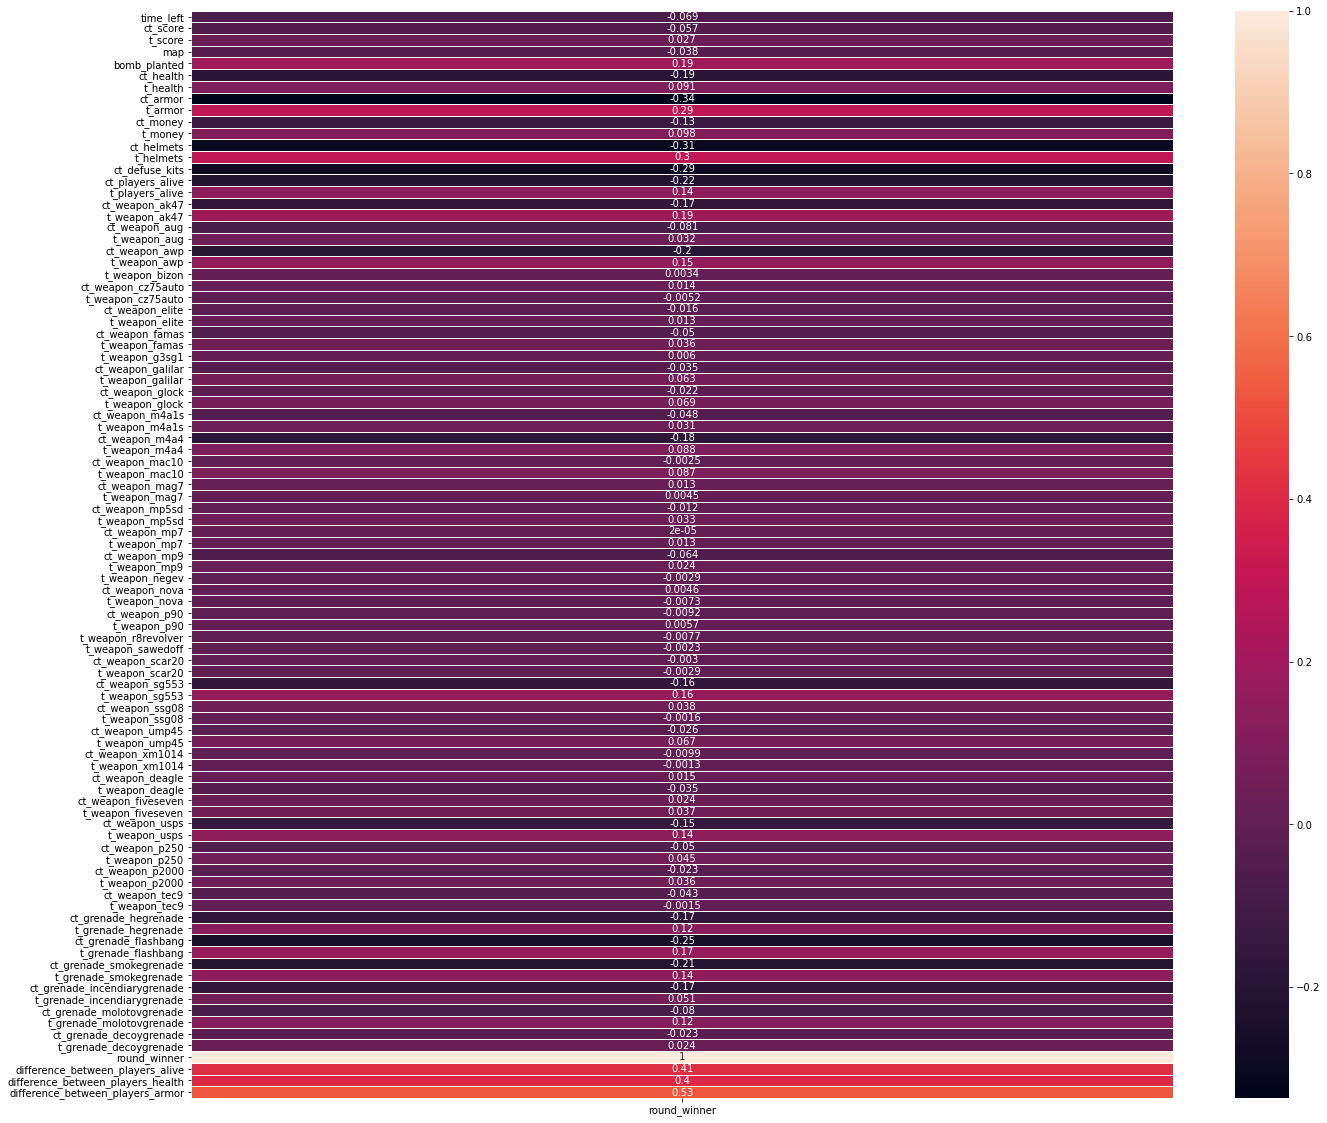

In [8]:
correlacio = dataset.corr()
plt.figure(figsize = (22,20))
ax = sns.heatmap(correlacio[["round_winner"]],annot=True,linewidths=.5)
plt.show()

#### Some Feture Selection

As we have so many features, we can do a feature selection(in which the data will be also standarized) in order to reduce the number of features that are going to be used

In [9]:
X_train, X_test,Y_train, Y_test=feature_selection_and_dataset_split(dataset,feature_selection=True)

total features: 92
selected features: 92
features with coefficients shrank to zero: 0
total features: 92
selected features: 30
Index(['bomb_planted', 'ct_health', 'ct_armor', 't_armor', 'ct_money',
       't_money', 't_helmets', 't_players_alive', 'ct_weapon_ak47',
       't_weapon_ak47', 'ct_weapon_aug', 'ct_weapon_awp', 't_weapon_awp',
       'ct_weapon_famas', 't_weapon_galilar', 'ct_weapon_m4a1s',
       'ct_weapon_m4a4', 't_weapon_mac10', 'ct_weapon_mp9', 'ct_weapon_sg553',
       't_weapon_sg553', 'ct_weapon_ssg08', 'ct_weapon_usps',
       't_grenade_flashbang', 't_grenade_smokegrenade',
       'ct_grenade_incendiarygrenade', 't_grenade_molotovgrenade',
       'difference_between_players_alive', 'difference_between_players_health',
       'difference_between_players_armor'],
      dtype='object')
features with coefficients shrank to zero: 0
Index([], dtype='object')


Now we are going to work with 30 features(33% of the original data)

### 4. Models

As we have so many samples, training models and searching Hyperparameters is so expensive, so it will not be done at this notebook(you can see an example of how to do it at(poner link github) ).

The results of the Hyperparameter search,are:

| Method         | Data used | Accuracy           | Hyperparameters                                                                                                                                                       | Time(seconds) | Number of iterations |
|----------------|-----------|--------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------|----------------------|
| Logistic       | 33%       | 0.7523895106608938 | {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.0003138337860695424}                                                                                                  | 1140          | 100                  |
| Logistic       | 100%      | 0.7505782060794011 | {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.0023463152069802705}                                                                                                  | 5283          | 25                   |
| Random Forest  | 33%       | 0.8654113226043624 | {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None,  'min_samples_leaf': 1, 'min_samples_split': 2,  'n_estimators': 188}           | 10395         | 100                  |
| Random Forest  | 100%      | 0.858768074503717   | {'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None,  'min_samples_leaf': 1, 'min_samples_split': 2,  'n_estimators': 120}            | 11460         | 20                   |
| CatBoost       | 33%       | 0.8417612940119271 | {'learning_rate': 0.1005, 'max_depth': 9}                                                                                                                             | 11346         | 50                   |
| CatBoost       | 100%      | 0.8319542763421571 | {'learning_rate': 0.1205, 'max_depth': 4}                                                                                                                             | 11196         | 15                   |
| LGBM           | 33%       | 0.8598153745609018 | {'reg_alpha': 0.70305655040732, 'num_leaves': 1250, 'num_iterations': 150, 'max_depth': -1, 'learning_rate': 0.4103147752802211}                                      | 2846          | 100                  |
| LGBM           | 100%      | 0.8236087941225211 | {'reg_alpha': 0.01, 'num_leaves': 1250, 'num_iterations': 150, 'max_depth': -1, 'learning_rate': 0.15}                                                                | 4532          | 100                  |
| XGBoost        | 33%       | 0.7980965607385018 | {'colsample_bytree': 0.7012362120853994, 'gamma': 3.543969952820899, 'max_depth': 15, 'min_child_weight': 7.0, 'reg_alpha': 109.0, 'reg_lambda': 0.35977544396941163} | 740           | 100                  |
| XGBoost        | 100%      | 0.8095123657852987 | {'colsample_bytree': 0.7012362120853994, 'gamma': 3.543969952820899, 'max_depth': 15, 'min_child_weight': 7.0, 'reg_alpha': 109.0, 'reg_lambda': 0.35977544396941163} | 2003          | 100                  |
| Decission Tree | 33%       | 0.7991994118127604 | {'min_samples_leaf': 2, 'max_depth': None}                                                                                                                            | 304           | 100                  |
| Decission Tree | 100%      | 0.7362688830352703 | {'min_samples_leaf': 3, 'max_depth': None}                                                                                                                            | 1800          | 100                  |

We can have a look at some confussion matrices:

* Random Forest

![Image 1](https://github.com/OriolBenitez/Cas_Kaggle/blob/main/pictures/cm_RandomForest.png?raw=true)

* CatBoost

![Image 2](https://github.com/OriolBenitez/Cas_Kaggle/blob/main/pictures/cm_catboost.png?raw=true)

* Decision Tree

![Image 3](https://github.com/OriolBenitez/Cas_Kaggle/blob/main/pictures/cm_dt.png?raw=true)

(if you want to see advanced stats like f1_score here you have how to do it [GitHub](https://github.com/OriolBenitez/Cas_Kaggle#demo)

### 5. Conclusions

After all the analysis and the results obtained, the following conclusions can be exposed:
* The map is an usefull variable whenever to decide which team is going to win the round.
* Random Forest, LGBM and Catboost are good models to make this predictions. Random Forest has shown the best results, so in case that we wanted to choose a predictor that guesses the round-winner it would be the chosen one. Thinking about real aplications of a predictor, a live-time predictor would be usefull for those who bet, at this case, LGBM would be the best algorithm to choose because Random Forest takes to much time to make a prediction.
* The original data contained lots of features that resulted not to be usefull.